In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import random

import matplotlib.pyplot as plt

from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from skorch import NeuralNetClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans

In [3]:
seed = 42
feature_size = 24
baseline_accuracy = 0.8

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

random.seed(seed)
torch_seed = random.randint(0, 2 ** 32 - 1)
numpy_seed = random.randint(0, 2 ** 32 - 1)
torch.manual_seed(torch_seed)
torch.cuda.manual_seed(torch_seed)
np.random.seed(numpy_seed)

Using device: cuda


In [4]:
class SigmoidNeuralNetwork(nn.Module):
    def __init__(self, input_size: int, layer_size: int = 64):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(input_size, layer_size),
            nn.ReLU(),
            nn.Linear(layer_size, layer_size),
            nn.ReLU(),
            nn.Linear(layer_size, layer_size),
            nn.ReLU(),
            nn.Linear(layer_size, 1),
        )

        self.layers.apply(self._init_weights)

    def forward(self, x):
        return self.layers(x).view(-1)
    
    def clasiffy(self, x):
        return torch.round(nn.Sigmoid()(self.forward(x))).view(-1).long()
    
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)

In [5]:
def load_data(feature_size: int):
    X = np.load('../Datasets/kryptonite-%s-X.npy'%(feature_size))
    y = np.load('../Datasets/kryptonite-%s-y.npy'%(feature_size))

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

    scaler = StandardScaler().fit(X_train)

    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    X_train = np.where(X_train >= 0, np.float32(1.0), np.float32(-1.0))
    X_test = np.where(X_test >= 0, np.float32(1.0), np.float32(-1.0))

    return X_train, y_train, X_test, y_test

In [6]:
X_train, y_train, X_test, y_test = load_data(feature_size)

In [7]:
net = NeuralNetClassifier(
    module=SigmoidNeuralNetwork,
    max_epochs=50,
    criterion=nn.BCEWithLogitsLoss,
    optimizer=torch.optim.Adam,
    optimizer__lr=0.01,
    batch_size=2048,
    module__input_size=feature_size,
    device=device,
)

params = {
    'optimizer__lr': [0.01],
    'max_epochs': [100],
    'batch_size': [4096],
    'module__layer_size': [256],
    'optimizer__weight_decay': [1e-3],
}

gs = GridSearchCV(net, params, refit=False, cv=10, scoring='accuracy', n_jobs=-1, verbose=2)
clf = gs.fit(X_train, y_train.astype(float))

Fitting 10 folds for each of 1 candidates, totalling 10 fits


In [8]:
print("Best parameters found: ", gs.best_params_)
print("Best accuracy found: ", gs.best_score_)

Best parameters found:  {'batch_size': 4096, 'max_epochs': 100, 'module__layer_size': 256, 'optimizer__lr': 0.01, 'optimizer__weight_decay': 0.001}
Best accuracy found:  0.8003645833333334


In [9]:
from skorch.callbacks import EpochScoring

net = NeuralNetClassifier(
    module=SigmoidNeuralNetwork,
    max_epochs=100,
    criterion=nn.BCEWithLogitsLoss,
    optimizer=torch.optim.Adam,
    optimizer__lr=gs.best_params_['optimizer__lr'],
    optimizer__weight_decay=gs.best_params_['optimizer__weight_decay'],
    batch_size=gs.best_params_['batch_size'],
    module__input_size=feature_size,
    module__layer_size=gs.best_params_['module__layer_size'],
    device=device,
    callbacks=[
        EpochScoring(scoring='accuracy', name='train_acc', on_train=True),
    ],
    train_split=None,
)

net = net.fit(X_train, y_train.astype(float))

  epoch    train_acc    train_loss     dur
-------  -----------  ------------  ------
      1       0.4970        0.9825  0.2638
      2       0.4974        0.6933  0.1497
      3       0.5059        0.6931  0.1480
      4       0.5095        0.6930  0.1471
      5       0.5133        0.6929  0.1439
      6       0.5175        0.6928  0.1447
      7       0.5186        0.6927  0.1379
      8       0.5217        0.6925  0.2495
      9       0.5210        0.6923  0.1420
     10       0.5202        0.6920  0.1370
     11       0.5217        0.6915  0.1471
     12       0.5250        0.6911  0.1360
     13       0.5289        0.6906  0.1408
     14       0.5305        0.6901  0.1606
     15       0.5317        0.6899  0.1476
     16       0.5346        0.6893  0.1331
     17       0.5353        0.6888  0.2440
     18       0.5369        0.6885  0.1375
     19       0.5364        0.6889  0.1429
     20       0.5403        0.6885  0.1496
     21       0.5462        0.6869  0.1455
     22    

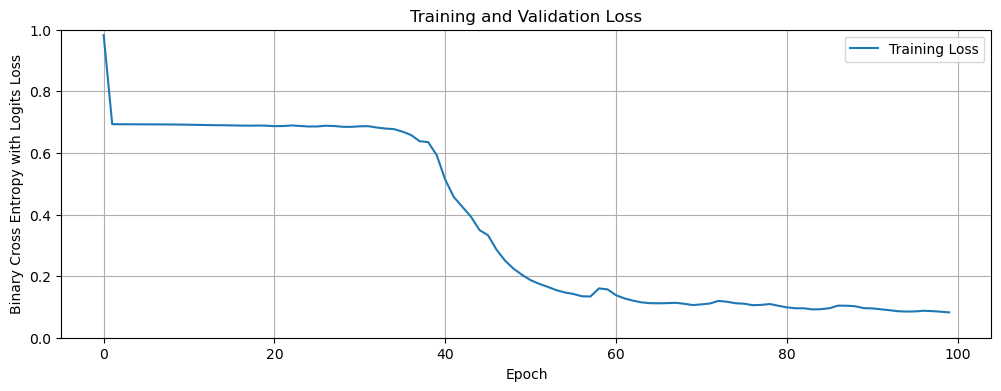

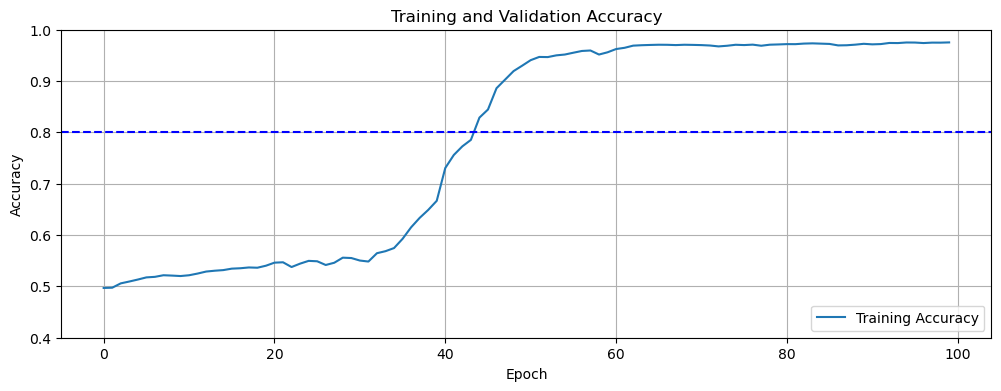

In [11]:
train_loss = net.history[:, 'train_loss']
# valid_loss = net.history[:, 'valid_loss']

train_acc = net.history[:, 'train_acc']
# valid_acc = net.history[:, 'valid_acc']

plt.figure(figsize=(12, 4))
plt.plot(train_loss, label='Training Loss')
# plt.plot(valid_loss, label='Validation Loss')
plt.legend()
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Binary Cross Entropy with Logits Loss")
plt.ylim(0, 1.0)
plt.grid()
plt.legend(loc='upper right')
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(train_acc, label='Training Accuracy')
# plt.plot(valid_acc, label='Validation Accuracy')
plt.axhline(y=baseline_accuracy, color='b', linestyle='--')
plt.legend()
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0.4, 1.0)
plt.grid()
plt.legend(loc='lower right')
plt.show()
